# 12 - Binary Classification with DNS and Combined Dataset

Characteristics of this notebook include:

  * Combined dataset used
  * Tokenizing 300 words from DNS queries based on freq
  * No Geolocation


## Restore previously saved df_sample DataFrame

In order to allow us to commence our training without having to repeat the previous data preparation steps, we will now load the df_sample dataframe using the pandas built-in from_json method.

In [17]:
from pathlib import Path
import pandas as pd
import os
from time import time
start = time()

cwd = Path.cwd()

file_path = os.path.join(cwd, 'saved_datasets', 'combined_dataset_dns.json' )
df_sample = pd.read_json(file_path)
end = time()
print(f"[+] Loaded pandas dataframe from disk in {(end-start):.2f} secs")

[+] Loaded pandas dataframe from disk in 4.15 secs


# the fun starts here...

We'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures


In [18]:
from sklearn.model_selection import train_test_split
import numpy as np

df_sample['is_iot'] = np.where(df_sample['device_type'] == 'Other', 0, 1)
df_sample.drop('device_type', axis='columns', inplace=True)

In [19]:
features = df_sample.drop('is_iot', axis=1).values
labels = df_sample['is_iot'].values

In [20]:
df_sample.shape[1]

312

In [21]:
features.shape[1]

311

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [23]:
print(len(labels), len(Y_train), len(Y_test), sep='::')

32799::26239::6560


In [24]:
#  This is new
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, Y_train)
bm.score(X_test, Y_test)

0.5092987804878049

# Classification Problems

*A quick recap of the various hyper-parameters to be used in the model for each type of classification problem:*

**Binary Classification Problem**

A problem where you classify an example as belonging to one of two classes.

The problem is framed as predicting the likelihood of an example belonging to class one, e.g. the class that you assign the integer value 1, whereas the other class is assigned the value 0.

 - Output Layer Configuration: `One node with a sigmoid activation unit`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

**Multi-Class Classification Problem**

A problem where you classify an example as belonging to one of more than two classes.

The problem is framed as predicting the likelihood of an example belonging to each class.

 - Output Layer Configuration: `One node for each class using the softmax activation function`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

class ModelFactory():

    def __init__(self, *args, **kwargs):
        self.params = args
        print(f'[+] Initialised with params: {self.params}')
        if 'model_name' in kwargs:
            self.model_name = kwargs['model_name']

    def get_model(self):

        model = Sequential()
        model.add(Dense(self.params[0], input_dim=features.shape[1], activation='relu'))
        if len(self.params) > 1:
            for it in self.params[1:]:
                eval(f"model.add(Dense({it}, activation='relu'))")
                eval(f"model.add(Dropout(0.2))")
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, 
                                verbose=1, mode='auto', restore_best_weights=True)
        
        return model

In [26]:
from pathlib import Path
cwd = Path.cwd()
NEEDS_TRAINING = True

if NEEDS_TRAINING:

    model_a = ( ModelFactory(64,128,64).get_model(), 'ModelA' )
    model_b = ( ModelFactory(32,64,32).get_model(),  'ModelB' )

    histories = []

    for my_mod in [model_a, model_b]: 
        mod, mod_name = my_mod
        history = mod.fit(X_train, Y_train, epochs=67, batch_size=10, shuffle=True, verbose=2)
        # Serialise model to json
        model_json = mod.to_json()
        filepath = os.path.join(
                                cwd,
                                'saved_models',
                                f'{mod_name}_binary_dns.json'
                                )
        with open(filepath, "w") as json_file:
            json_file.write(model_json)

        # Serialize weights to HDF5
        filepath = os.path.join(
                            cwd,
                            'saved_models',
                            f'{mod_name}_binary_dns.h5'
                            )
        mod.save_weights(filepath)
        loss, accuracy = mod.evaluate(X_test, Y_test, verbose=2)
        print(f'{my_mod[1]}: Loss = {loss}, Accuracy={accuracy}')
        histories.append([history, loss, accuracy])
else:
    pass

[+] Initialised with params: (64, 128, 64)
[+] Initialised with params: (32, 64, 32)
Epoch 1/67
 - 5s - loss: 0.1093 - accuracy: 0.9550
Epoch 2/67
 - 5s - loss: 0.0686 - accuracy: 0.9716
Epoch 3/67
 - 5s - loss: 0.0627 - accuracy: 0.9731
Epoch 4/67
 - 5s - loss: 0.0599 - accuracy: 0.9752
Epoch 5/67
 - 5s - loss: 0.0569 - accuracy: 0.9759
Epoch 6/67
 - 5s - loss: 0.0550 - accuracy: 0.9776
Epoch 7/67
 - 5s - loss: 0.0529 - accuracy: 0.9774
Epoch 8/67
 - 5s - loss: 0.0529 - accuracy: 0.9771
Epoch 9/67
 - 5s - loss: 0.0529 - accuracy: 0.9774
Epoch 10/67
 - 5s - loss: 0.0524 - accuracy: 0.9777
Epoch 11/67
 - 5s - loss: 0.0512 - accuracy: 0.9776
Epoch 12/67
 - 5s - loss: 0.0508 - accuracy: 0.9781
Epoch 13/67
 - 5s - loss: 0.0504 - accuracy: 0.9782
Epoch 14/67
 - 5s - loss: 0.0508 - accuracy: 0.9785
Epoch 15/67
 - 5s - loss: 0.0499 - accuracy: 0.9789
Epoch 16/67
 - 5s - loss: 0.0500 - accuracy: 0.9790
Epoch 17/67
 - 5s - loss: 0.0505 - accuracy: 0.9792
Epoch 18/67
 - 5s - loss: 0.0497 - accur

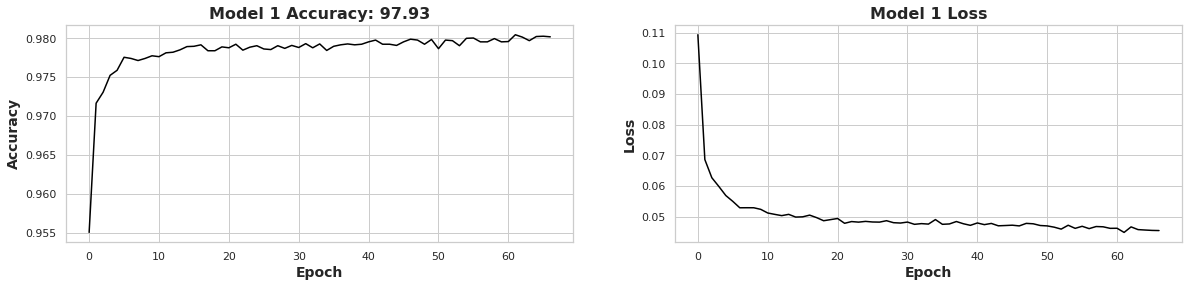

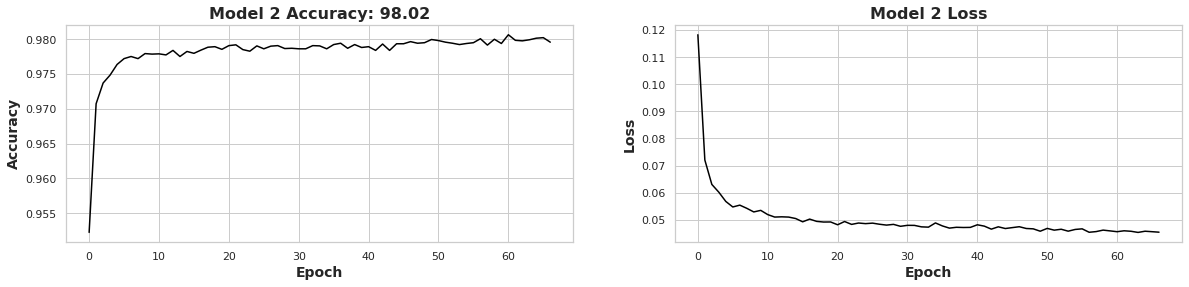

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (20,4)
LEGEND = False

if NEEDS_TRAINING:

    for idx, hist_data in enumerate(histories, 1):
        history, loss, accuracy = hist_data
        # Plot training & validation accuracy values
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(history.history['accuracy'], color='black')
        plt.title(f'Model {idx} Accuracy: {(accuracy*100.0):.2f}', fontsize=16, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14, fontweight='bold')
        if LEGEND: ax1.legend('Train', loc='upper left')

        # # Plot training & validation loss values
        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(history.history['loss'], color='black')
        plt.title(f'Model {idx} Loss', fontsize=16, fontweight='bold')
        plt.ylabel('Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14, fontweight='bold')
        if LEGEND: ax2.legend('Train', loc='upper left')
        plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/binary{idx}_dns.png', dpi=150)
        plt.show()
else:
    pass

In [28]:
from keras.models import model_from_json
import os
import json

In [29]:
# load json and create model
import os
from pathlib import Path
cwd = Path.cwd()

json_file = open(
                os.path.join(
                    cwd,
                    'saved_models',
                    'ModelB_binary_dns.json'
                ), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(cwd, 'saved_models', 'ModelB_binary_dns.h5'))
print("[+] Loaded model from disk")

[+] Loaded model from disk


In [30]:
# These functions were adapted from:
#  Jeff Heaton, McKelvey School of Engineering, Washington University in St. Louis

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc(pred,y):
    plt.rcParams["figure.figsize"] = (8,8)
    plt.rcParams["figure.dpi"] = 150
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/roc_binary.png', dpi=150)
    plt.show()

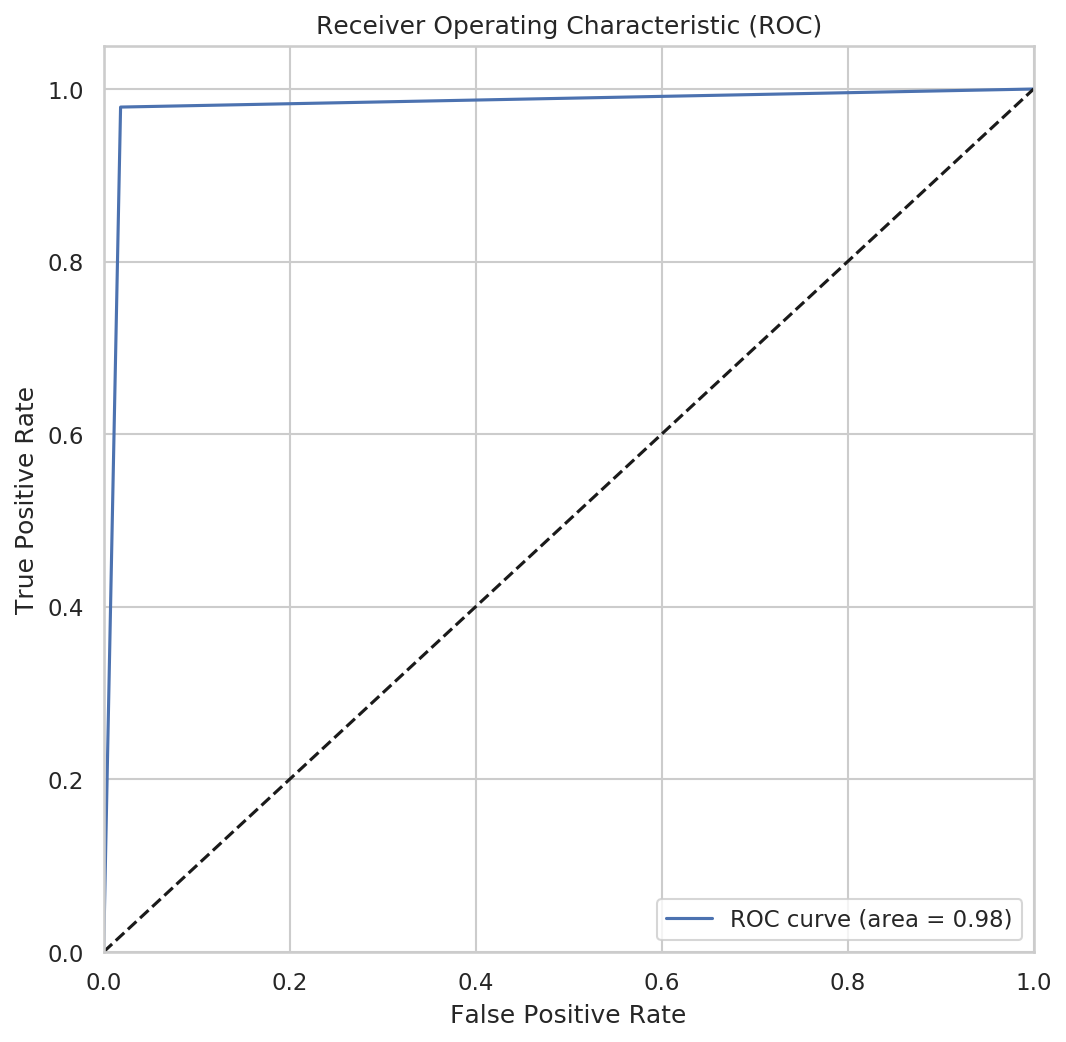

In [31]:
pred = loaded_model.predict(X_test)
pred = np.where(pred >= 0.5, 1, 0)
plot_roc(pred,Y_test)

## Calculation of Classification Accuracy

Accuracy refers to the number of rows in our dataset where the model predicted the target class.  Accuracy is only used for classification, not regression.

\begin{align}
accuracy = \frac{c}{N}
\end{align}

Where:
 * c is the number correct, and
 * N is the size of the evaluated set
 
Keras returns the probability percentage for each class.  We'll change these into actual model predictions with n.where.

In [32]:
pred = loaded_model.predict(X_test)
pred = np.where(pred >= 0.5, 1, 0)

In [33]:
from sklearn.metrics import confusion_matrix
y_predict = loaded_model.predict(X_test)
y_predict = np.where(y_predict >= 0.5, 1, 0)
cm_df = pd.DataFrame(
    confusion_matrix(Y_test, y_predict),
        columns = [
            'Predict Non-IoT',
            'Predict IoT'
        ],
        index = [
            'True Non-IoT',
            'True IoT'
        ])

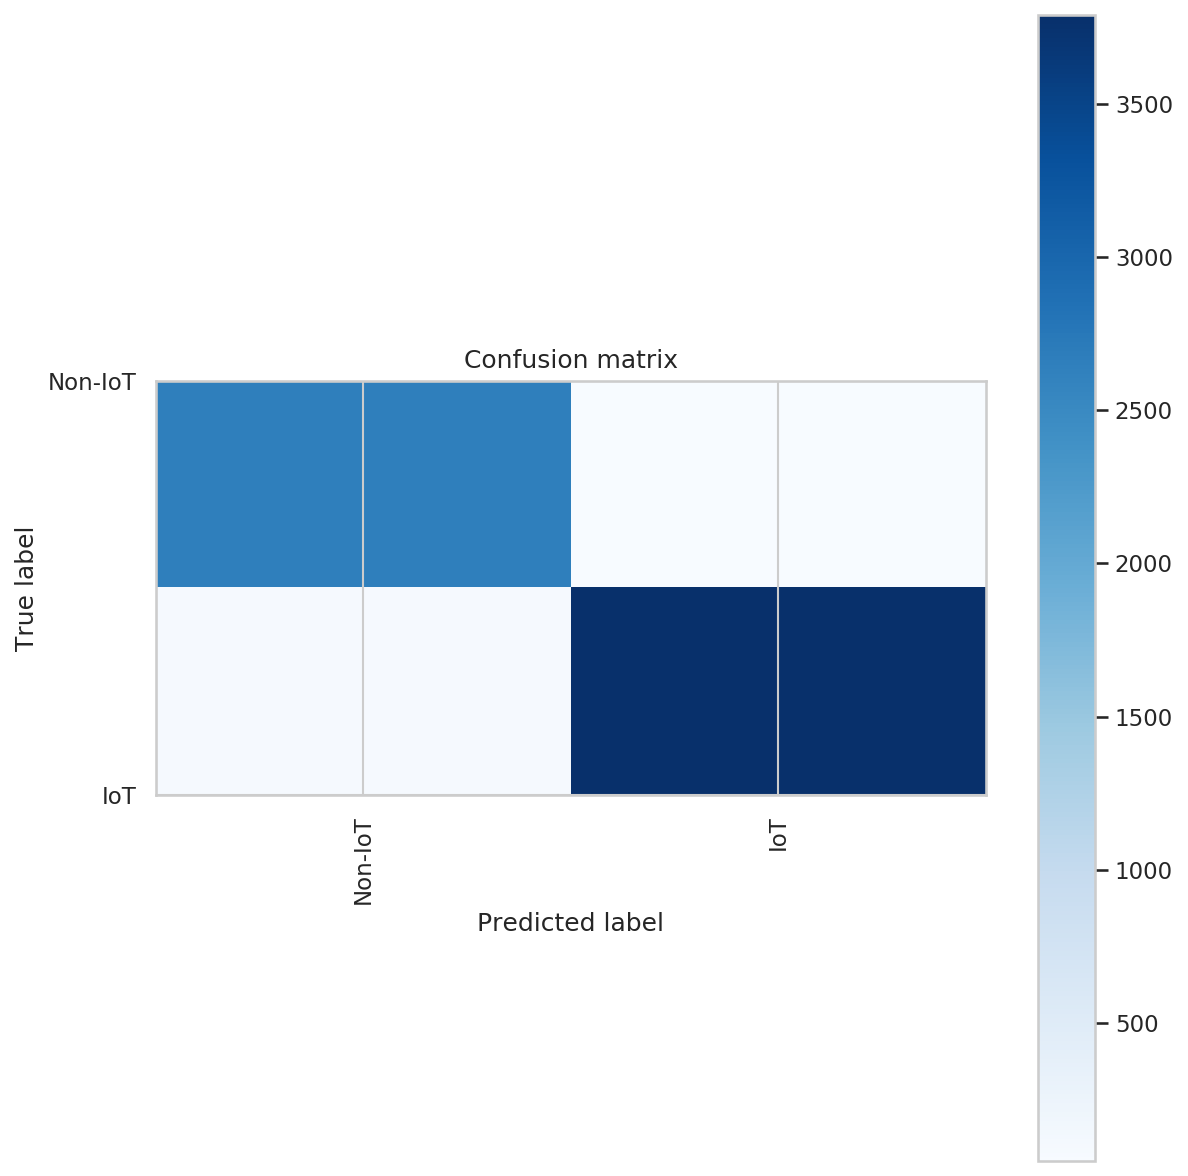

In [34]:
plt.figure()
plot_confusion_matrix(cm_df, ['Non-IoT', 'IoT'])
plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/confusion_matrix_binary_dns.png', dpi=150)


In [35]:
cm_df

,Predict Non-IoT,Predict IoT
True Non-IoT,2639,49
True IoT,81,3791
